# Bayesian KDE digit recognition

This example looks at Bayesian generative classification with KDE, and demonstrates how to use the custom estimator within this repository (model/bayesian_kde_classifier.py).

Let’s consider one optical character recognition problem: the identification of handwritten digits.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
digits.images.shape

(1797, 8, 8)

The images data is a three-dimensional array: 1,797 samples, each consisting of an 8x8 image of integer pixels in the range 0..16

In [2]:
digits.images[1796]

array([[ 0.,  0., 10., 14.,  8.,  1.,  0.,  0.],
       [ 0.,  2., 16., 14.,  6.,  1.,  0.,  0.],
       [ 0.,  0., 15., 15.,  8., 15.,  0.,  0.],
       [ 0.,  0.,  5., 16., 16., 10.,  0.,  0.],
       [ 0.,  0., 12., 15., 15., 12.,  0.,  0.],
       [ 0.,  4., 16.,  6.,  4., 16.,  6.,  0.],
       [ 0.,  8., 16., 10.,  8., 16.,  8.,  0.],
       [ 0.,  1.,  8., 12., 14., 12.,  1.,  0.]])

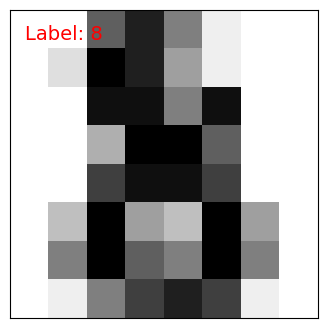

In [3]:
import matplotlib.pyplot as plt

i = 1796  # choose an index between 0 and 1796

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
ax.set_xticks([]); ax.set_yticks([])
ax.text(0.05, 0.95, f"Label: {digits.target[i]}", transform=ax.transAxes, color='red',
        fontsize=14, va='top')
plt.show()

 Let’s visualize the first hundred of these

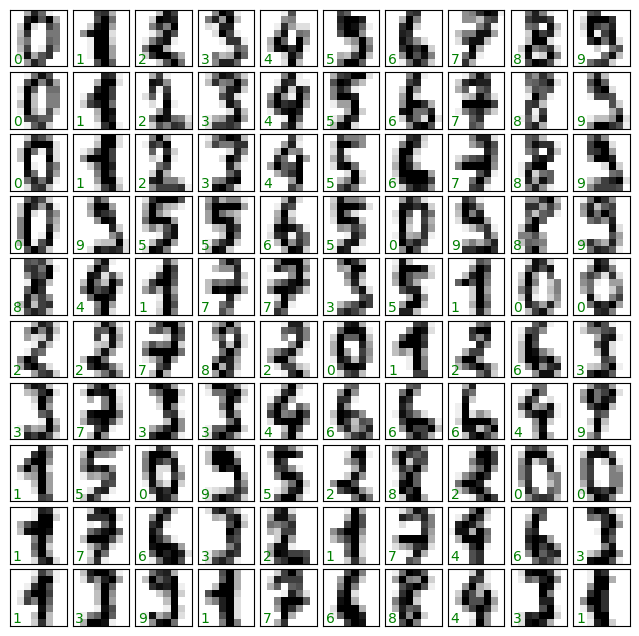

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

In order to work with this data within Scikit-Learn, we need a two-dimensional, [n_samples, n_features] representation. We can accomplish this by treating each pixel in the image as a feature—that is, by flattening out the pixel arrays so that we have a length-64 array of pixel values representing each digit.

In [ ]:
X = digits.data # scikit-learn already flattens the 8x8 images into 64-dimensional vectors
X.shape

(1797, 64)

In [6]:
y = digits.target
y.shape

(1797,)

### Hyperparameters and model validation

Before training, we start by saving some data to test the model later on unseen images.

In [ ]:
from sklearn.model_selection import train_test_split


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.1,      # 10% for validation
)


print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation set: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")

Training set: X_train shape = (1617, 64), y_train shape = (1617,)
Validation set: X_val shape = (180, 64), y_val shape = (180,)


To find the best hyperparameter, let's compute the cross-validation score for a range of candidate KDE bandwidths using the GridSearchCV meta-estimator.

In [10]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from model.bayesian_kde_classifier import bayesian_kde_classifier # Custom estimator

bandwidths = 10 ** np.linspace(0, 2, 100)

grid = GridSearchCV(
    bayesian_kde_classifier(), # Custom estimator again
    param_grid={'bandwidth': bandwidths},
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best bandwidth:", grid.best_params_['bandwidth'])
print("Best CV score:", grid.best_score_)

scores = grid.cv_results_['mean_test_score']


Best bandwidth: 5.09413801481638
Best CV score: 0.9888659557390207


The model achieved a 98.9% on training accuracy. Nice.

We can plot the cross-validation score as a function of bandwidth.

{'bandwidth': np.float64(5.09413801481638)}
accuracy = 0.9888659557390207


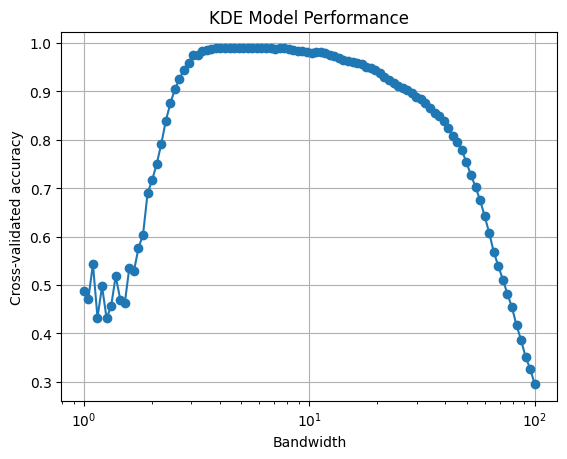

In [11]:
import matplotlib.pyplot as plt

bandwidths = grid.cv_results_['param_bandwidth'].data.astype(float)
scores = grid.cv_results_['mean_test_score']

plt.figure()
plt.semilogx(bandwidths, scores, marker='o')
plt.xlabel('Bandwidth')
plt.ylabel('Cross-validated accuracy')
plt.title('KDE Model Performance')
plt.grid(True)

print(grid.best_params_)
print('accuracy =', grid.best_score_)

plt.show()

Now we can fit the training data using the best hyperparameter, and test the custom model on images it has never seen.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Initialize the classifier
clf = bayesian_kde_classifier(bandwidth=5.09413801481638, kernel='gaussian') # Use the best bandwidth found on grid.best_score_

# Train on training data
clf.fit(X_train, y_train)

# Predict on validation data
y_val_pred = clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Optional: Get prediction probabilities
# y_val_proba = clf.predict_proba(X_val)
# print(f"\nPrediction probabilities shape: {y_val_proba.shape}")
# print(f"Sample probabilities (first 5 instances):\n{y_val_proba[:5]}")

Validation Accuracy: 0.9722

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      1.00      0.95        18
           2       1.00      1.00      1.00        16
           3       0.96      1.00      0.98        23
           4       1.00      1.00      1.00        27
           5       1.00      0.78      0.88         9
           6       0.94      1.00      0.97        15
           7       1.00      1.00      1.00        23
           8       1.00      0.90      0.95        20
           9       0.94      0.94      0.94        17

    accuracy                           0.97       180
   macro avg       0.97      0.96      0.97       180
weighted avg       0.97      0.97      0.97       180


Confusion Matrix:
[[12  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0]
 [ 0 

The model achieved results of 97.2% test accuracy, that's great!